In [158]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sv
import plotly.graph_objs as pg
import plotly.figure_factory as ffc
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [159]:
 #-----------SPRACOVANIE DAT--------------#

df = pd.read_csv("weather_data.csv")
test_data = pd.read_csv("weather_data.csv")

# najskor pridam do irradiance vsade 0 aby sa neodstranilo prilis vela zaznamov

df["Irradiance"] = df["Irradiance"].fillna(0.0)

# zistili sme ze v nasom datasete sa nachádza 277 null hodnôt okrem (stlpca Irradiance)
# pre dataset nasich rozmerov je to pomerne mali pocet zaznamov a preto sme sa 
# ich rozhodli odstranit
print(f"There are: {df.isnull().sum().sum()} null values in dataset")

# Konvertovanie stĺpca 'UV Index' na číselný typ
df['UV Index'] = pd.to_numeric(df['UV Index'], errors='coerce')

print(df.isnull().sum())

# odstranenie prazdnych zaznamov
df = df.dropna()
df = df.drop_duplicates(keep='first')
df = df.fillna(0)

df = df.drop('Irradiance', axis=1)


There are: 277 null values in dataset
Temperature             44
Humidity                35
Wind Speed              38
Precipitation (%)       33
Cloud Cover              0
Atmospheric Pressure    44
UV Index                37
Season                   0
Visibility (km)         47
Location                 0
Weather Type             0
Irradiance               0
dtype: int64


In [160]:
# zistenie kolko roznych druhov Cloud Cover sa nachadza v DB a ich zakodovnie
# Cloud Cover sme si vybrali druh kodovanie: Label Encoding 

unique_values_cloud = df['Cloud Cover'].unique()
print(f"Unique words: {unique_values_cloud}")
print(f"Number of unique words cloud: {len(unique_values_cloud)}")

df['Cloud Cover'] = pd.factorize(df['Cloud Cover'])[0]

unique_values_location = df['Location'].unique()
print(f"Unique words: {unique_values_location}")
print(f"Number of unique words location: {len(unique_values_location)}")

df['Location'] = pd.factorize(df['Location'])[0]

# na stlpec season sme vybrali druh zakódovania One-Hot Encoding

df_one_hot = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, df_one_hot], axis = 1)

df = df.drop(columns=['Season'])


df['Season_Winter'] = pd.to_numeric(df['Season_Winter'], errors='coerce')
df['Season_Summer'] = pd.to_numeric(df['Season_Summer'], errors='coerce')
df['Season_Autumn'] = pd.to_numeric(df['Season_Autumn'], errors='coerce')
df['Season_Spring'] = pd.to_numeric(df['Season_Spring'], errors='coerce')

# Zobrazenie dátových typov každého stĺpca
print(df.dtypes)

# Vyfiltrovanie stĺpcov, ktoré nie sú číselného typu (float alebo int)
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print("Stĺpce, ktoré nie sú číselného typu:", non_numeric_columns)



Unique words: ['partly cloudy' 'clear' 'overcast' 'cloudy']
Number of unique words cloud: 4
Unique words: ['inland' 'mountain' 'coastal' 'island']
Number of unique words location: 4
Temperature             float64
Humidity                float64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover               int64
Atmospheric Pressure    float64
UV Index                float64
Visibility (km)         float64
Location                  int64
Weather Type             object
Season_Autumn             uint8
Season_Spring             uint8
Season_Summer             uint8
Season_Winter             uint8
dtype: object
Stĺpce, ktoré nie sú číselného typu: Index(['Weather Type', 'Season_Autumn', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')


In [161]:
# Vyhľadanie duplicitných záznamov

duplicate = df[df.duplicated()]
df = df.drop_duplicates()
print("Number of records in dataset: "+str(len(df)))
print("There are: " + str(len(duplicate)) + " duplicates.")



Number of records in dataset: 12924
There are: 0 duplicates.


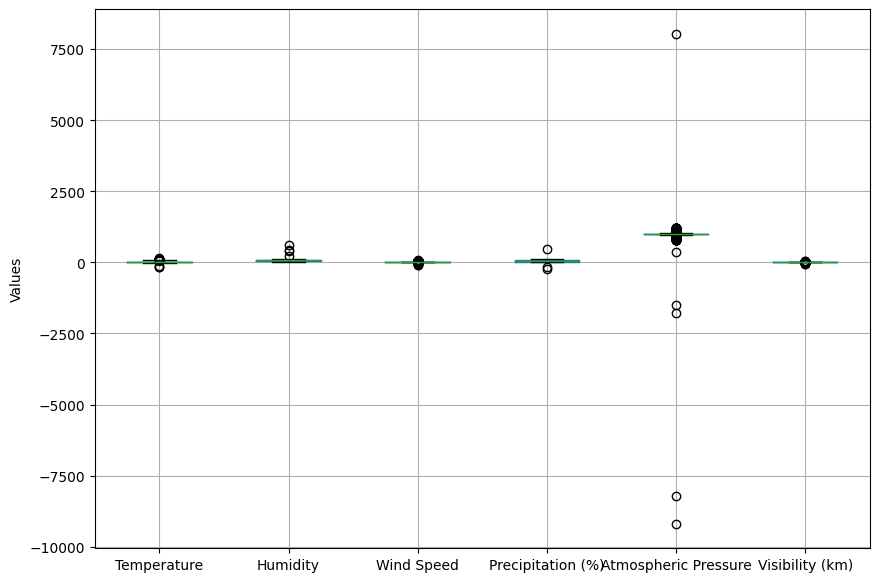

In [162]:
# Teraz potrebujeme odstrániť outliery v stĺpcos v ktorých boli originálne numerické hodnoty

numeric_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'
                  ]

# vypisanie hodnot ako boxplot
df.boxplot(column=['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'],figsize=(10,7))
plt.ylabel("Values")
plt.show()

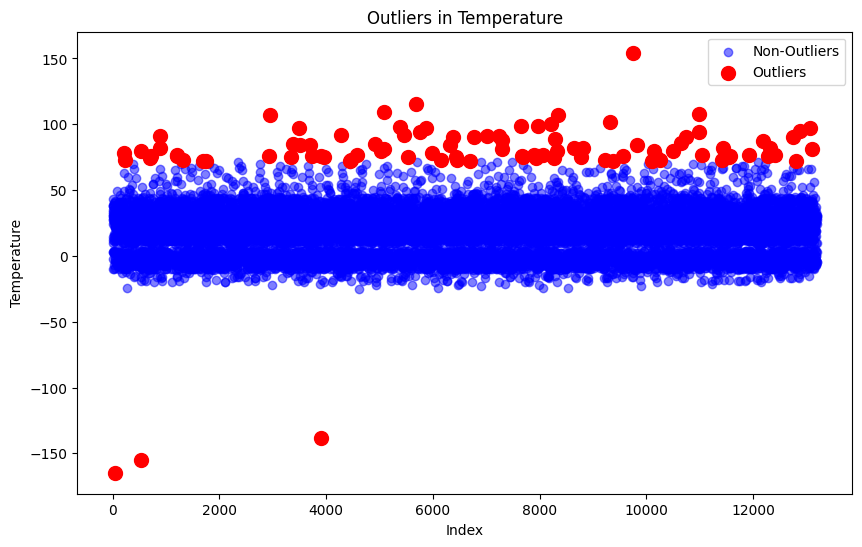

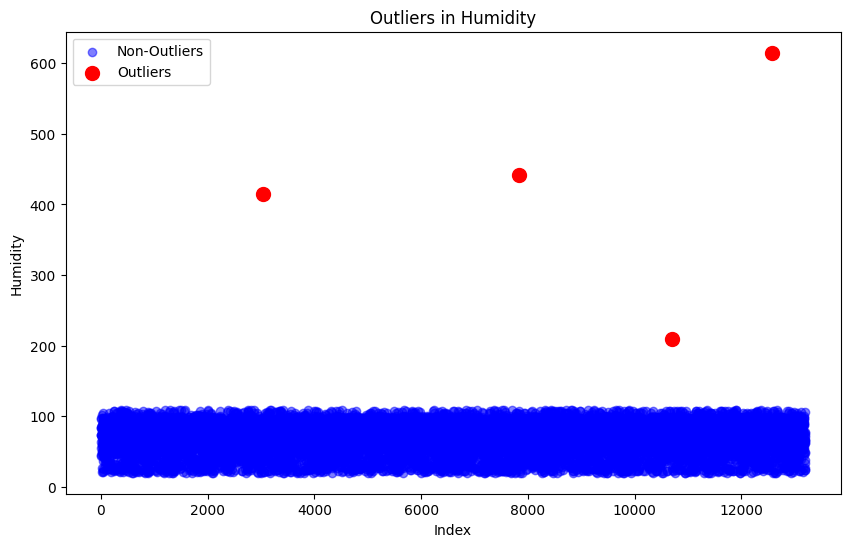

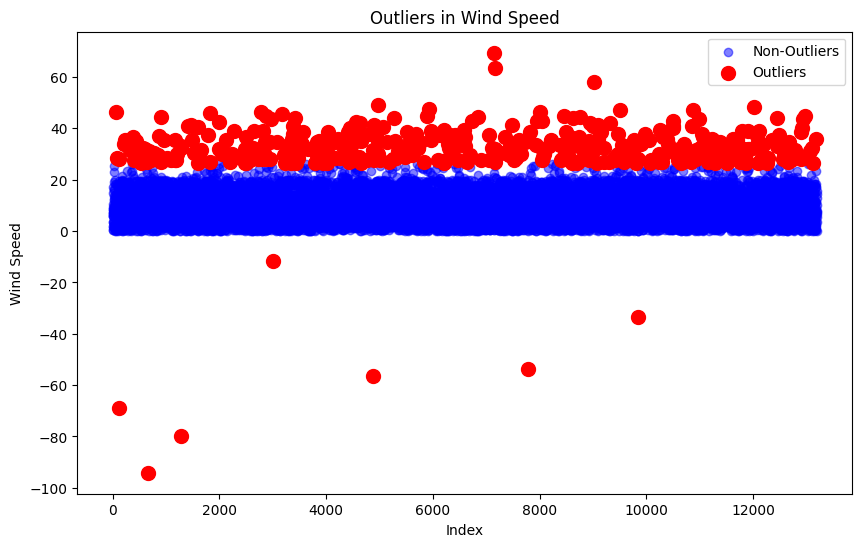

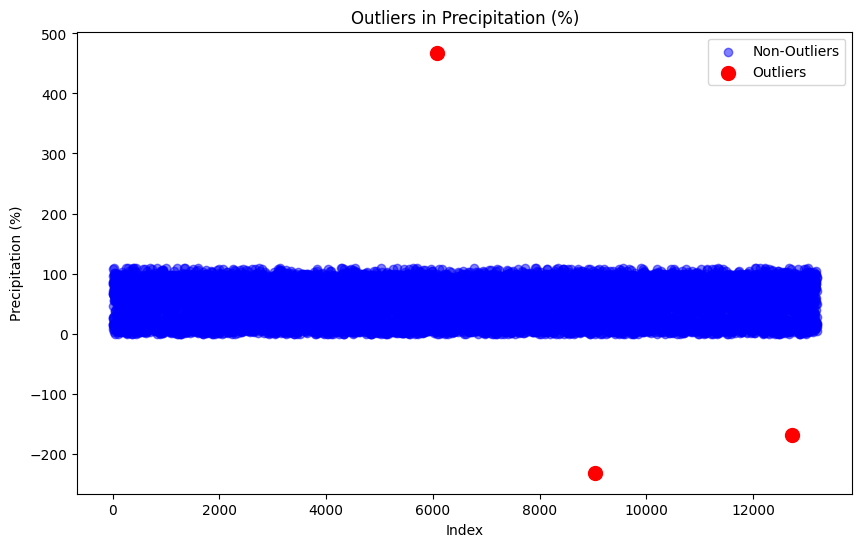

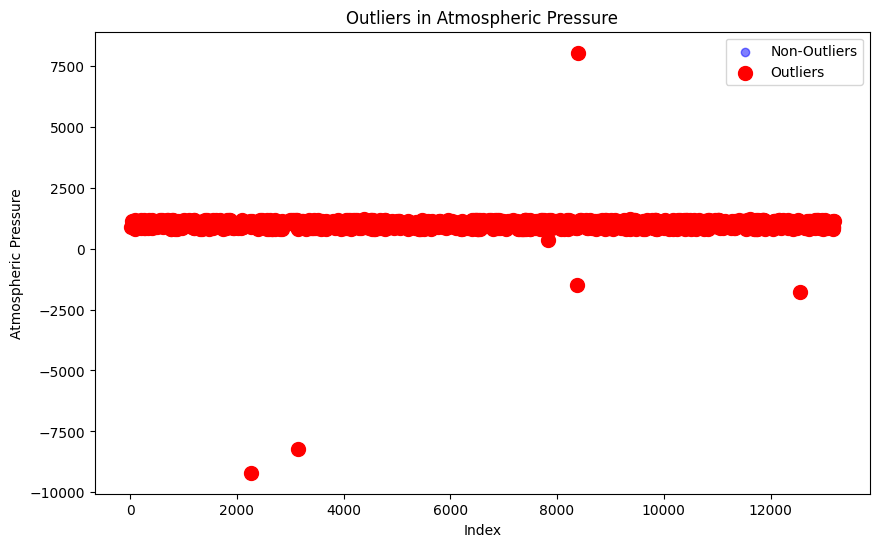

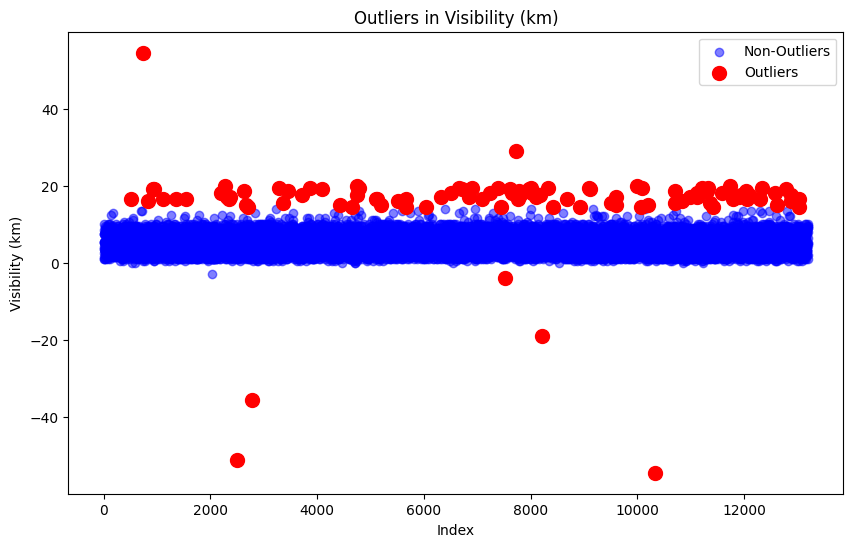

        Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  11405.000000  11405.000000  11405.000000       11405.000000   
mean      19.089695     69.389040      9.213196          51.892532   
std       15.927995     19.200608      5.611719          31.888903   
min      -24.000000     20.000000      0.000000           0.000000   
25%        7.000000     59.000000      5.000000          18.000000   
50%       22.000000     70.000000      8.500000          56.000000   
75%       30.000000     84.000000     13.500000          81.000000   
max       71.000000    100.000000     26.000000         100.000000   

        Cloud Cover  Atmospheric Pressure      UV Index  Visibility (km)  \
count  11405.000000          11405.000000  11405.000000     11405.000000   
mean       1.128979           1006.260715      3.627259         5.109600   
std        0.905635             12.931730      3.643200         2.609860   
min        0.000000            962.880000     -1.563806        -3

In [163]:

# Identifikovanie a odstraňovanie outlierov na základe IQR
def detect_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikácia outlierov
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Odstránenie outlierov
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean, outliers

# Aplikovanie na všetky číselné stĺpce
for column in numeric_columns:
    df, outliers = detect_and_remove_outliers(df, column)
    
    # Vizualizácia výsledkov
    plt.figure(figsize=(10, 6))
    
    plt.scatter(df.index, df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=100)
    
    plt.title(f"Outliers in {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Oprava neplatných hodnôt
df['Humidity'] = df['Humidity'].clip(lower=0, upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(lower=0, upper=100)

# Kontrola dát
print(df.describe())


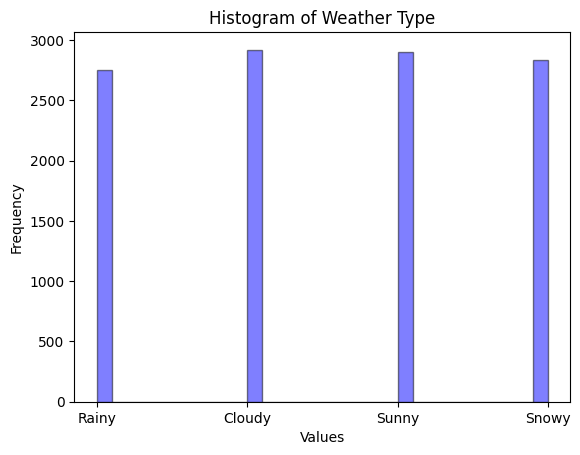

((6843, 13), (6843,), (2281, 13), (2281,), (2281, 13), (2281,))

In [164]:
X = df.drop(columns='Weather Type')
Y = df['Weather Type']

# Najprv rozdelíme dáta na trénovaciu a testovaciu množinu (60% tréning, 40% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)

# Potom rozdelíme trénovaciu množinu na tréningovú a validačnú množinu (50% tréning, 50% validačná)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size=0.50, random_state=42)

# Výsledné množiny:
# X_train, y_train - Trénovacie dáta
# X_val, y_val - Validačné dáta
# X_test, y_test - Testovacie dáta

plt.hist(df['Weather Type'], bins=30, color='blue', edgecolor='black', alpha=0.5)  # Nahradiť target_column názvom stĺpca

plt.title('Histogram of Weather Type')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

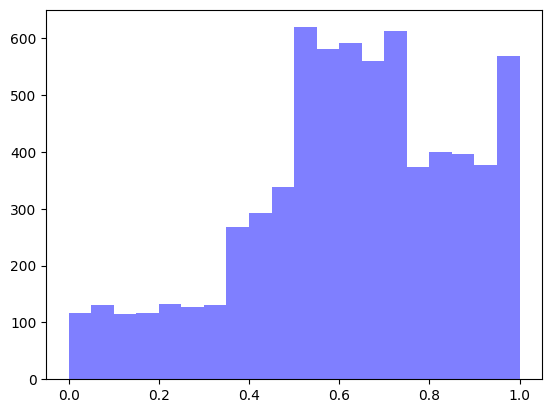

In [165]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train)

plt.hist(X_train_df[1], bins = 20, color = 'blue', alpha = 0.5)
plt.show()

model accuracy: 0.9302937308198159


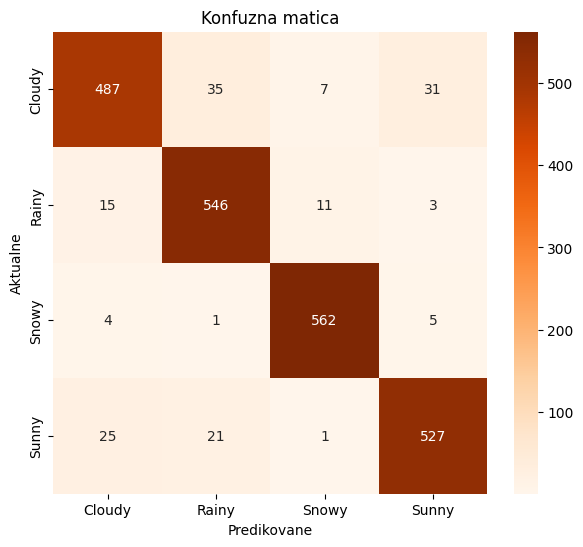

In [169]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzna matica")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

In [167]:
# korelacna matica
corr_matrix = px.imshow(df.corr())
corr_matrix.show()

C:\Users\mraff\AppData\Local\Temp\ipykernel_5988\2365527316.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

